# Google Earth Engine and its pal `geemap`

Hopefully Earth Engine needs no introduction, but it is a daunting resource both from a data and coding perspective. In addition to accessing Earth Engine via the code editor, Earth Engine has a [Python API](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api). Most function calls are identical, and both exploit [client- and server-side functions](https://developers.google.com/earth-engine/guides/client_server), which can be confusing as it is different than what we were doing in Session 1. 

Although GEE has some built-in data analysis and viz functions, our lord and savior Qiusheng Wu created [`geemap`](https://geemap.org/) to supplement the GEE Python API to help users familiar with Python data exploration and visualization tools. 

Your best workflow really comes down to what you are most comfortable doing - most StackExchange answers are either about the GEE JavaScript API or the Python geospatial stack, so if you want to use the two together, your best bet is leveraging `geemap` functions to get data in a format with which you are most comfortable /hottake

In [30]:
import geemap
import ee

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import os

import seaborn as sns
import matplotlib.pyplot as plt

The following commands must be called each time you start a new kernel. Make sure to open the link in a browser profile that has an account with Earth Engine access.

In [2]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


# Get shapefiles into Earth Engine

We're going back to our oldy but a goodie permafrost map. Let's see what this looks like, and its crs

PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["D_Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


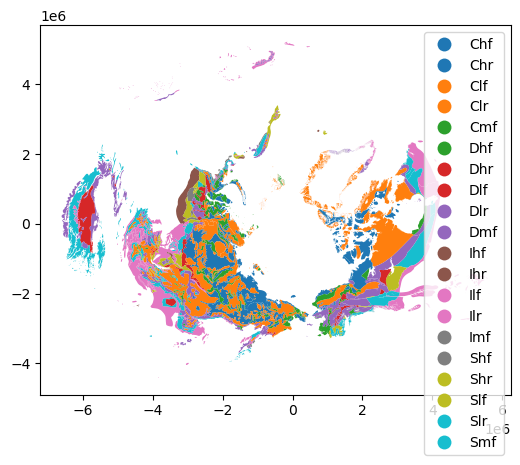

In [3]:
permafrost = gpd.read_file("../arctic-data/permaice.shp")

pf_filtered = permafrost.dropna(subset=['EXTENT'])

pf_filtered.plot(column='COMBO', legend=True)
print(pf_filtered.crs)

`geemaps`'s [documentation](https://geemap.readthedocs.io/en/latest/readme.html) lists all the great functions we can use, including a function that converts [`ee.FeatureCollection`s](https://developers.google.com/earth-engine/guides/feature_collections) to shapefiles.  

Here I am just going to grab the outline of Alaska - I'm sure it lives somewhere easy on one of these Arctic databases, but this was easiest for me and demonstrates an Earth Engine tool!

In [4]:
alaska = geemap.ee_to_shp(
    ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Alaska')),
    filename='../arctic-data/alaska.shp'
)

Generating URL ...
Please wait ...
Data downloaded to /dartfs/rc/lab/V/VecchioJ/computational-arctic-workshop/arctic-data/alaska.shp


I do this because you have to do a bunch of stupid `.map()` functions in the Earth Engine API to clip two complex shapefiles to each other, but GeoPandas makes it easy!

In [ ]:
# This is commented out because it definitely works but the OG permafrost shapefile was super weird when it got projected to pseudo-Mercator
# permafrost = geemap.shp_to_ee(
#     os.path.join(os.path.dirname(os.getcwd()),"./arctic-data/alaska_permafrost.shp"),
#      )
# permafrost_geoms = permafrost.map(lambda feature: feature.geometry())
# perma_clip = alaska.map(lambda feature: feature.intersection(permafrost_geoms, 1)); # 1 refers to the maxError argument

In [10]:
alaska = gpd.read_file("../arctic-data/alaska.shp").to_crs(pf_filtered.crs) # I think it came that way actually
permafrost_clipped = pf_filtered.clip(alaska)

# Note this is EXTREMELY efficient. You'd have to map over individual geometries in Earth Engine 

Let's take a look at our result in the WGS84 projection (a file downloaded from Earth Engine)

<Axes: >

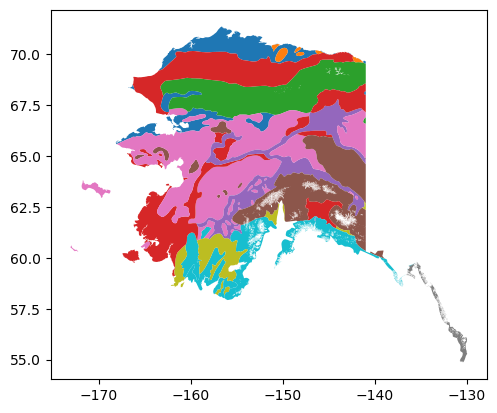

In [11]:
permafrost_clipped.to_crs('EPSG:4326').plot(column='COMBO')

Nice, so let's also save that 

In [12]:
permafrost_clipped.to_crs('EPSG:4326').to_file("../arctic-data/alaska_permafrost.shp")

## And now bring your newly clipped dataset into Earth Engine!

In [14]:
permafrost = geemap.shp_to_ee(
    "../arctic-data/alaska_permafrost.shp"
     )

`geemap` has a `Map()` tool that resembles the API of the JavaScript code editor. One thing is that if you add a layer to a map in one line, the whole Notebook's Map() instances will update

In [15]:
Map = geemap.Map()
Map.addLayer(permafrost, {}, 'permafrost')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Work with HydroSHED watershed boundaries

Earth Engine stores lots of vector data in addition to raster data, like the [HydroSHEDS](https://developers.google.com/earth-engine/datasets/tags/hydrosheds) global watershed delineation dataset. Since Earth Engine doesn't allow you to route flow or delineate watersheds on its servers, this is the best we get besides delineating our own watersheds and importing them. 

In [16]:
headwater_sheds = (
    ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_10") # Level 10 sheds are usually the smallest watershed units
    .filter(ee.Filter.equals(leftField = 'SUB_AREA', rightField = 'UP_AREA')) # this filter makes sure the watersheds represent the headwaters - they have no extra upstream drainage area
    .filterBounds(ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Alaska'))) # and only look at watersheds in ALaska
    )

In [17]:
Map.addLayer(headwater_sheds, {}, 'headwater sheds')
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Define key functions

Remember the client and server side functions? [`imageCollection.map()`](https://developers.google.com/earth-engine/guides/ic_mapping) is the powerful server-side function that applies a function to every item in a collection. It's kind of like the reverse syntax of a `for` loop where you do `image.map(function)`. 

Here are some function I'll use in the upcoming analyses

In [18]:
# Transfer the temporal metadata from each satellite image

def createTimeBand(image):
  return image.addBands(image.metadata('system:time_start').divide(3.154e10));
  # // Scale is now in years
  # // in the linear regression output.

In [19]:
# Produce an annual reduction of some ImageCollection (e.g. max NDVI for the year for 20 years, resulting in 20 images)

def annual_images(y): # y is a list of years 
    range_year = ee.Filter.calendarRange(y, y, 'year')
    range_month = ee.Filter.calendarRange(start_month, end_month, 'month')
    filtered_dataset = (index_collection
                        .filter(range_year)
                        .filter(range_month)
                        .map(createTimeBand)) # Needed for linear regression 
    # Combine the mean and standard deviation reducers.
    if analysis == 'mean':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
      )
    elif analysis == 'min' or analysis == 'max':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
      )
    elif analysis == 'median':
      reducers = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.median(),
        sharedInputs=True
      )

# Use the combined reducer to get the mean and SD of the image.
    stats0 = filtered_dataset.reduce(
      reducer=reducers,
    )

    return stats0.set('year',y)

# adapted from https://gis.stackexchange.com/questions/392834/transform-google-earth-engine-script-to-python-with-landsat-8-temporal-data

In [20]:
# MODIS-specific functions

# Mask out water
def maskWater(image):
    return image.updateMask(waterMask.select('water_mask').lt(1));

def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

# Example analysis: get pixelwise annual trend in maximum NDVI

Read about the MODIS product [here](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1#description).

In [21]:
# MODIS water mask is probably universally good to apply to all imagery (if you want to mask water!)
waterMask = ee.ImageCollection('MODIS/006/MOD44W').filter(ee.Filter.date('2015-01-01', '2015-01-02')).select('water_mask').first();

# This dataset is a composite that chooses the best-quality pixels
# per 16-day period, so no cloud masking is required.
ndvi_raw = ee.ImageCollection('MODIS/006/MOD13Q1').select('NDVI')
ndvi = ndvi_raw.map(maskWater).map(scale_factor);


Below I wrote an easy-to-adjust codeblock for making those annual image collections. 

In [22]:
# Options are 'mean', 'median', 'min' 'max'
analysis = 'max'

start_year=2000
end_year=2022
start_month=6
end_month=9
index_collection = ndvi

# Options are 'mean_std', 'mean_min_max', and 'median'
# I want to replace this with the "analysis" variable 
#reducer='mean_min_max'

years = ee.List.sequence(start_year,end_year)

yearwise_ndvi = years.map(annual_images)

# Make an ImageCollection from the list of images you just composited,
# since you need an ImageCollection for the linear fit reduction
yearCompCol = ee.ImageCollection.fromImages(yearwise_ndvi)

You may note that this takes no time to run, which seems wild, right? Turns out two things are happening:
1. Google's computers are huge so any server-side calculation will get paralellized and run quickly, but more importantly
2. You actually haven't calculated anything yet because everything is stil server-side. Google will only *run* the code when you give it a client-side function like plotting or exporting. 

In [23]:
# Get a pixelwise linear regression across the composited ImageCollection
# "select" is time and the band you are interested in
# The output is the slope of the line fit to each pixel's data over time
# and the timestep is "per year"
trend = yearCompCol.select(['system:time_start_mean', 'NDVI_' + analysis]).reduce(ee.Reducer.linearFit())

# 'system:time_start_mean' is my hacky way of doing time per scene
# The value is "the mean number of years since 1970 across the scene"
# which will just be the middle of the month(s) you chose in the year you chose

# The result is two outputs: "scale" is the slope and "offset" is the intercept

trend_clip = trend.clip(headwater_sheds)
#  Just easier to clip to an Image rather than ImageCollection, and Google doesn't care

*Now* we will plot our results! 

In [24]:
import geemap.colormaps as cm
palette = cm.palettes.ndvi

vis_params = {
    'min': -0.01,
    'max': 0.01,
    'palette': palette,
}

Map.addLayer(trend_clip.select('scale'), vis_params, 'NDVI trend')

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

Map.add_colorbar(vis_params, label='NDVI trend (value/year')

Map.addLayerControl()
Map

Map(bottom=17657.0, center=[64.28990955114661, -158.57666015625003], controls=(WidgetControl(options=['positio…

That is *so much computation* happening in the blink of an eye!

## Big data!!

Ok, but now we want the *data* itself. But when I say "data" remember that the fewer client-side functions you call, the better your code will perform (you can indeed query too much data at a time and Google will say nah in the form of a timeout error). 

This is where [reducing](https://developers.google.com/earth-engine/guides/reducers_intro) data is crucial (but not obligatory) for your big-data queries. Below I'll show an example of `ee.Reducer.mean()` for our data:

In [25]:
# Get the mean pixelwise trend for each watershed
basinData = trend.reduceRegions(collection=headwater_sheds,reducer=ee.Reducer.mean(), scale=250)

Here we use `geemap.ee_to_geopandas` which is a *client-side* function and therefore will actually process the code that is so far queued up. Often times you won't get an error message from `ee` until you call a client-side function, which makes debugging challenging. 

In [26]:
# Turn it into a geodataframe
# Rename columns so you know what you did 
# to_pandas ~ 30 seconds
output = geemap.ee_to_geopandas(basinData).rename(columns={"scale": analysis+'_trend_slope', "offset": analysis+"_trend_intercept"})

For whatever reason the conversion doesn't set a CRS, so I chose WGS84, but it might be Web Mercator (EPSG:3857) like the code editor CRS, not sure :shrug: might have to ask Qiusheng

In [27]:
output = output.set_crs('EPSG:4326') 

For ease of plotting, let's grab the centroid of the watershed as the watershed's representative latitude, but there is also the very fun [`gpd.representative_point()'](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.representative_point.html) that you should try too!

In [28]:
output['latitude'] = output.centroid.y

## Plot trend extracted from GEE with `seaborn`

Text(0, 0.5, 'Trend in greening, NDVI/year')

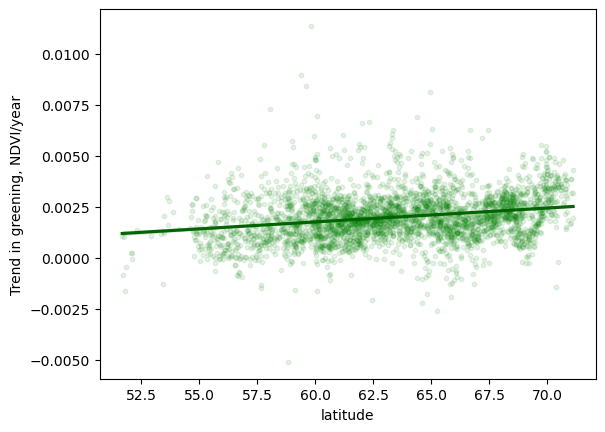

In [31]:
fig, ax = plt.subplots(dpi=100)

scatter = sns.regplot(
    x='latitude',
    y='max_trend_slope',
    data=output,
    scatter_kws={'alpha':0.1,
    's':10},
     line_kws={'color':'darkgreen', 
    #  'alpha':0.1,
     },
     color='green',
     ax=ax
    )
ax.set_ylabel("Trend in greening, NDVI/year")

Ah, a statistically significant greening at higher latitudes in our watersheds!

Can you think of anything else to play with this data? Maybe a spatial join to the permafrost shapefile? Or maybe some extra data layers from Earth Engine?

## Example: raster and vector data together with two legends

(-180.0, -125.0)

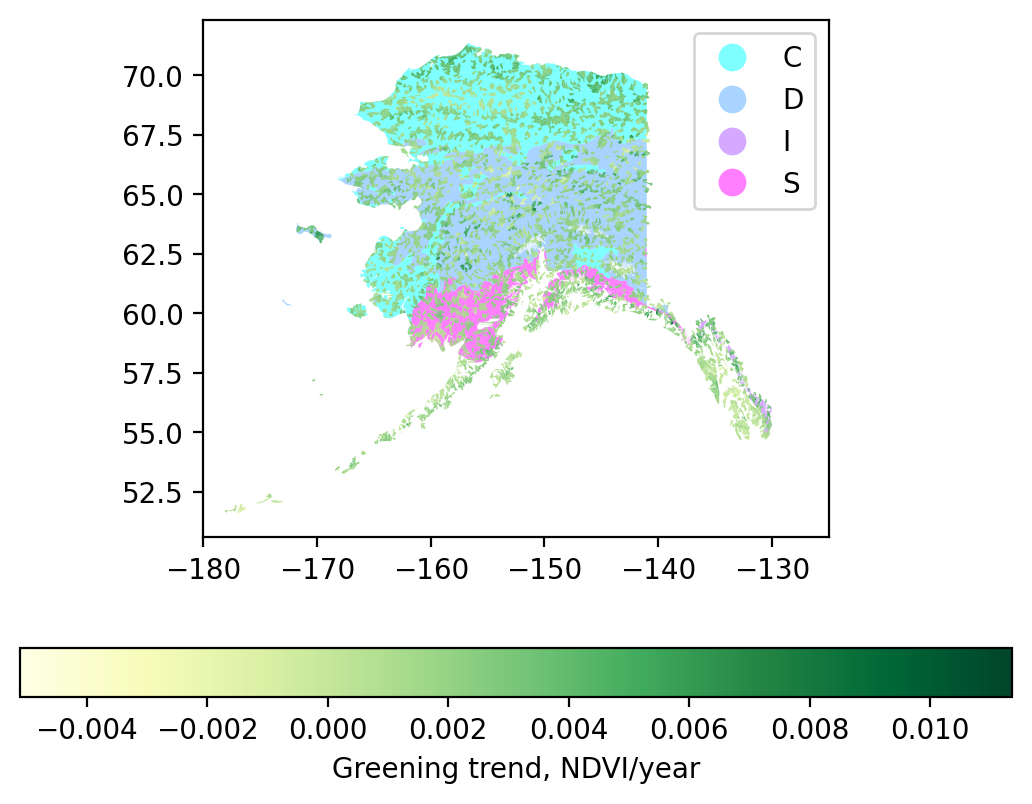

In [32]:
fig, ax = plt.subplots(dpi=200)

alaska = permafrost_clipped.to_crs('EPSG:4326').plot(column='EXTENT', alpha=0.5, cmap='cool', legend=True, ax=ax)
sheds = output.plot(column='max_trend_slope', cmap='YlGn', ax=ax, legend=True, 
legend_kwds={'label': "Greening trend, NDVI/year",
                        'orientation': "horizontal"})

ax.set_xlim(-180,-125)

# Get our friends the CALM data

So, wouldn't it be cool to have some climate data for our CALM data points? Or any other data for that matter? Let's get on it!

In [33]:
# get the calm points into ee
calm = geemap.shp_to_ee(
    "CALM_points.shp",
    encoding = "windows-1254"
    )

Let's grab mean annual temperature from the [WorldClim BIO Variables V1](https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO) dataset. There are [so many climate datasets](https://developers.google.com/earth-engine/datasets/tags/climate) on Earth Engine you could go wild!

In [34]:
MeanAT = ee.Image('WORLDCLIM/V1/BIO').select('bio01').multiply(0.1)

I read somewhere that if you have point data to save processing time you should use `reduceRegions`. 

In [37]:
stats = MeanAT.reduceRegions(
        collection = calm, # feature collection here
        reducer = ee.Reducer.mean().setOutputs(["MAT"]),
        scale = 100,
    )


Time to bring this into the client side!

In [38]:
extracted = geemap.ee_to_geopandas(stats)
extracted.columns

Index(['geometry', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', 'Latitude',
       'Longitude', 'MAT', 'Method', 'Site_Code', 'Site_Name', 'URL',
       'average', 'intercept', 'pvalue', 'rvalue', 'slope', 'stderr', '1991',
       '1992', '1990'],
      dtype='object')

OK, some weird reordering of the columns, so if you want to mess around with this data more, remember/fix that!

## Plot `ee`-extracted values for CALM data

(-2.0, 10.0)

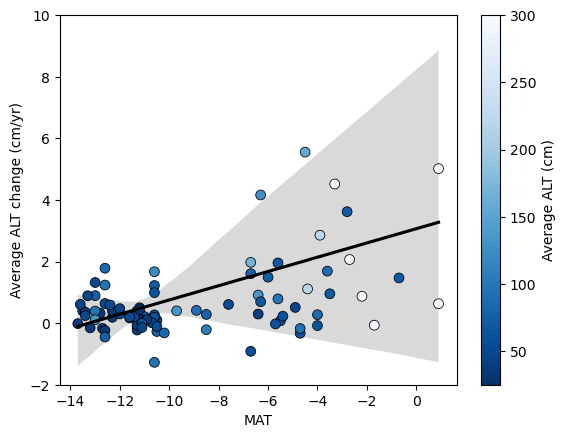

In [62]:
# A little trick: regplot doesn't take hue but scatter does
# So layer them!

fig, ax = plt.subplots(dpi=100)

regression = sns.regplot(
    x='MAT',
    y='slope',
    scatter=False,
    data=extracted,
    line_kws={'color':'black', 
     },
     ax=ax,
    )
scatter2 = sns.scatterplot(
    x='MAT',
    y='slope',
    hue='average',
    data=extracted,
    s=50,
    edgecolor='k',
    palette="Blues_r",
    hue_norm=(25,300), # seaborn's version of vmin and vmax
    ax=ax,
    zorder=1
    )

# Some pro tips to make a more useful colorbar for the hue data
# https://stackoverflow.com/questions/49761221/make-seaborn-show-a-colorbar-instead-of-a-legend-when-using-hue-in-a-bar-plot
norm = plt.Normalize(25,300)
sm = plt.cm.ScalarMappable(cmap="Blues_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
cb = ax.figure.colorbar(sm)
cb.set_label("Average ALT (cm)")

ax.set_ylabel("Average ALT change (cm/yr)")
ax.set_ylim(-2, 10)

So warmer places aren't necessary thawing faster either (since that [confidence interval is 95 percentile by default](https://seaborn.pydata.org/generated/seaborn.regplot.html))...similar to what Sade and I found!

# Hackathon promt

You now have the Arctic at your fingertips fam!! Go do science!